## Protein Contact Map Exploration
### This notebook:
#### - Loads some .pdb files
#### - Extracts amino acid sequences and Cα coordinates
#### - Computes contact maps (< 8 Å)
#### - Visualizes sequences and contact matrices

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
from Bio.PDB import PDBParser, is_aa
from Bio.PDB import PDBParser, Polypeptide

### List the files

In [2]:
train_dir = "protein_data/train"
test_dir = "protein_data/test"

# List sample files
train_files = [f for f in os.listdir(train_dir) if f.endswith(".pdb")]
print(f"Found {len(train_files)} train PDB files.")
test_files = [f for f in os.listdir(test_dir) if f.endswith(".pdb")]
print(f"Found {len(test_files)} test PDB files.")
print("Example files:", train_files[:5])

Found 15000 train PDB files.
Found 500 test PDB files.
Example files: ['8CUR.pdb', '164L.pdb', '3WHI.pdb', '4RUY.pdb', '4N08.pdb']


### Function to parse a PDB file
### Extract:
#### - Sequence of residues (as 1-letter code)
#### - Coordinates of each residue's Cα atom

In [3]:
RESIDUE_MAP = {
    "ALA": "A", "ARG": "R", "ASP": "D", "CYS": "C", "CYX": "C",
    "GLN": "Q", "GLU": "E", "GLY": "G", "HIS": "H", "HIE": "H",
    "ILE": "I", "LEU": "L", "LYS": "K", "MET": "M", "ASN": "N",
    "PHE": "F", "PRO": "P", "SEC": "U", "SER": "S", "THR": "T",
    "TRP": "W", "TYR": "Y", "VAL": "V"
    }

def parse_pdb(pdb_path):
    """Parse a PDB file and extract sequence + Cα coordinates."""
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_path)
    seq = []
    coords = []

    for model in structure:
        for chain in model:
            for residue in chain:
                if not is_aa(residue, standard=False):
                    continue
                resname = residue.get_resname().strip()
                # Use task-specific mapping
                if resname in RESIDUE_MAP:
                    seq.append(RESIDUE_MAP[resname])
                if "CA" in residue:
                    coords.append(residue["CA"].get_coord())

    seq = "".join(seq)
    coords = np.array(coords)
    return seq, coords

# Try parsing a few proteins
example_file = os.path.join(train_dir, train_files[0])
seq, coords = parse_pdb(example_file)

print(f"Example file: {train_files[0]}")
print(f"Sequence length: {len(seq)}")
print(f"Coordinates shape: {coords.shape}")
print("Sequence (first 50 residues):", seq[:50])


Example file: 8CUR.pdb
Sequence length: 274
Coordinates shape: (274, 3)
Sequence (first 50 residues): MENFQKVEKIGEGTYGVVYKARNKLTGEVVALKKIRLDREISLLKELNHP


### Compute and visualize contact map
#### Contacts are defined as residue pairs within 8 Å.

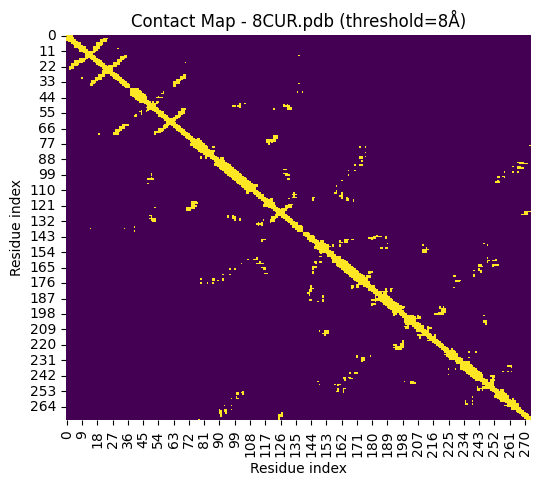

In [4]:
def compute_contact_map(coords, threshold=8.0):
    """Compute binary contact map (1 if dist < threshold)."""
    dist = np.linalg.norm(coords[:, None, :] - coords[None, :, :], axis=-1)
    contacts = (dist < threshold).astype(int)
    return dist, contacts

dist, contacts = compute_contact_map(coords)

plt.figure(figsize=(6, 5))
sns.heatmap(contacts, cmap="viridis", cbar=False)
plt.title(f"Contact Map - {train_files[0]} (threshold=8Å)")
plt.xlabel("Residue index")
plt.ylabel("Residue index")
plt.show()

### Analyze a few more proteins for sequence length distribution

In [6]:
def get_seq_length(pdb_file):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("", pdb_file)
    seq_len = 0
    seq = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if not is_aa(residue, standard=False):
                    continue
                resname = residue.get_resname().strip()
                # Use task-specific mapping
                if resname in RESIDUE_MAP:
                    seq.append(RESIDUE_MAP[resname])
    return len(seq)

lens = []
for f in tqdm(train_files, desc="Counting sequence lengths"):
    pdb_path = os.path.join(train_dir, f)
    lens.append(get_seq_length(pdb_path))




Counting sequence lengths: 100%|████████████████████████████████████████████████████| 15000/15000 [11:58<00:00, 20.88it/s]


In [7]:
lens = np.array(lens)
for cutoff in [500, 700, 1000, 1500, 2000, 5000, 10000]:
    coverage = np.mean(lens <= cutoff) * 100
    print(f"max_residue={cutoff:<5} → covers {coverage:.2f}% of dataset")

max_residue=500   → covers 71.10% of dataset
max_residue=700   → covers 83.55% of dataset
max_residue=1000  → covers 92.15% of dataset
max_residue=1500  → covers 97.03% of dataset
max_residue=2000  → covers 98.83% of dataset
max_residue=5000  → covers 99.89% of dataset
max_residue=10000 → covers 99.97% of dataset


### Plotting the sequence lengths after removing the outlier lengths

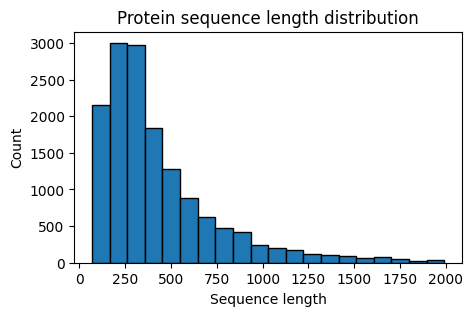

In [8]:
lens = [i for i in lens if i < 2000]
plt.figure(figsize=(5,3))
plt.hist(lens, bins=20, edgecolor="k")
plt.title("Protein sequence length distribution")
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.show()

### Most of the sequences have lengths in the range of 150-400 almost. Let's plot in more detail

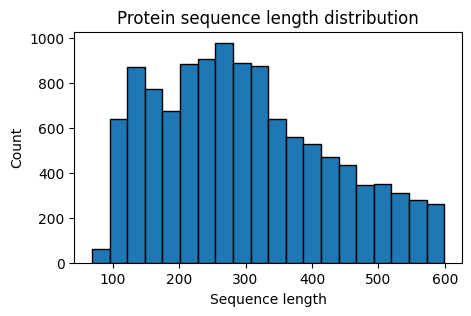

In [9]:
lens = [i for i in lens if i < 600]
plt.figure(figsize=(5,3))
plt.hist(lens, bins=20, edgecolor="k")
plt.title("Protein sequence length distribution")
plt.xlabel("Sequence length")
plt.ylabel("Count")
plt.show()

## ESM2 Embeddings exploration

### Statistics per protein

Found 14995 embedding files

Protein 0 (390 residues, embedding dim 320):
Mean embedding value: -0.012913
Std deviation: 0.442757
Min: -3.962454, Max: 1.784487
L2 norm per residue: mean=7.921515

Protein 1 (994 residues, embedding dim 320):
Mean embedding value: -0.016911
Std deviation: 0.458670
Min: -3.148336, Max: 2.435924
L2 norm per residue: mean=8.209777

Protein 2 (2964 residues, embedding dim 320):
Mean embedding value: -0.011728
Std deviation: 0.405388
Min: -5.164183, Max: 1.837452
L2 norm per residue: mean=7.248946

Protein 3 (776 residues, embedding dim 320):
Mean embedding value: -0.014900
Std deviation: 0.458680
Min: -3.140925, Max: 2.041117
L2 norm per residue: mean=8.208893

Protein 4 (1838 residues, embedding dim 320):
Mean embedding value: -0.013312
Std deviation: 0.437506
Min: -5.340078, Max: 2.062435
L2 norm per residue: mean=7.814095


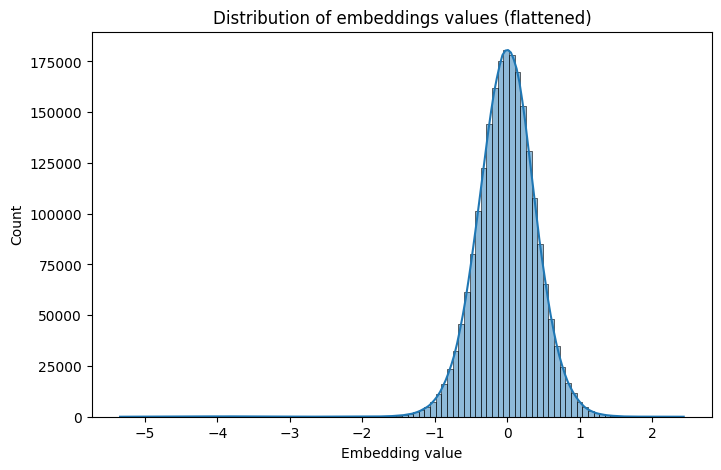

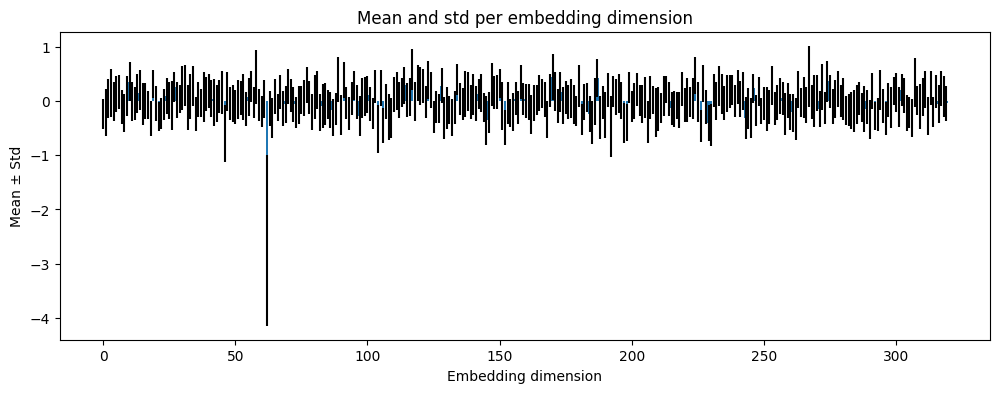

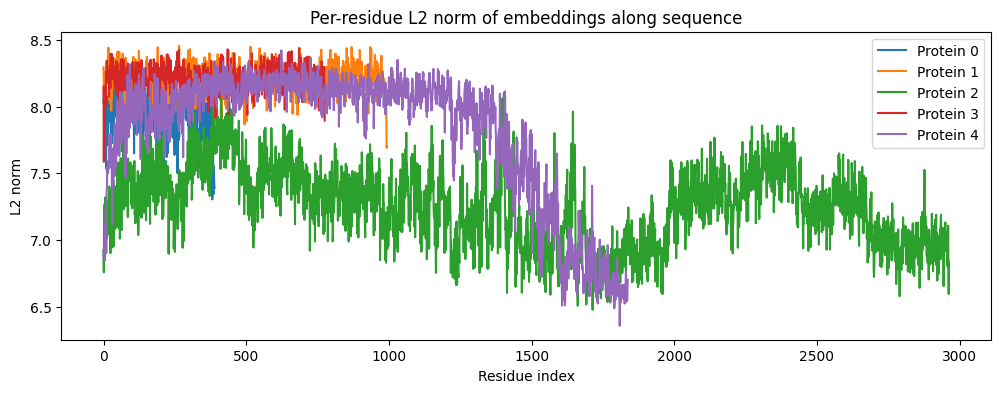

In [17]:
def embeddings_statistics(emb_dir):
    emb_files = [f for f in os.listdir(emb_dir) if f.endswith(".pt")]
    print(f"Found {len(emb_files)} embedding files")
    
    # load a few sample embeddings
    sample_embeddings = []
    for f in emb_files[:5]:  # first 5 proteins
        emb = torch.load(os.path.join(emb_dir, f), weights_only=True)  # shape (L, emb_dim)
        sample_embeddings.append(emb)
    
    # ----------------------------
    # Statistics per protein
    # ----------------------------
    for idx, emb in enumerate(sample_embeddings):
        print(f"\nProtein {idx} ({emb.shape[0]} residues, embedding dim {emb.shape[1]}):")
        print(f"Mean embedding value: {emb.mean().item():.6f}")
        print(f"Std deviation: {emb.std().item():.6f}")
        print(f"Min: {emb.min().item():.6f}, Max: {emb.max().item():.6f}")
        print(f"L2 norm per residue: mean={emb.norm(dim=1).mean().item():.6f}")

    all_emb = torch.cat(sample_embeddings, dim=0)  # concatenate residues
    plt.figure(figsize=(8,5))
    sns.histplot(all_emb.cpu().numpy().flatten(), bins=100, kde=True)
    plt.title("Distribution of embeddings values (flattened)")
    plt.xlabel("Embedding value")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(12,4))
    dim_means = all_emb.mean(dim=0).cpu().numpy()
    dim_stds = all_emb.std(dim=0).cpu().numpy()
    plt.bar(range(len(dim_means)), dim_means, yerr=dim_stds)
    plt.title("Mean and std per embedding dimension")
    plt.xlabel("Embedding dimension")
    plt.ylabel("Mean ± Std")
    plt.show()

    plt.figure(figsize=(12,4))
    for idx, emb in enumerate(sample_embeddings):
        norms = emb.norm(dim=1).cpu().numpy()
        plt.plot(norms, label=f"Protein {idx}")
    plt.title("Per-residue L2 norm of embeddings along sequence")
    plt.xlabel("Residue index")
    plt.ylabel("L2 norm")
    plt.legend()
    plt.show()

emb_dir = "embeddings/cache_fp32/train"  # folder where 320-dim ESM2 embeddings are stored
embeddings_statistics(emb_dir)

Found 14995 embedding files

Protein 0 (390 residues, embedding dim 64):
Mean embedding value: 0.014848
Std deviation: 0.740757
Min: -3.523975, Max: 4.181159
L2 norm per residue: mean=5.906064

Protein 1 (994 residues, embedding dim 64):
Mean embedding value: 0.022087
Std deviation: 0.894875
Min: -4.392615, Max: 5.664021
L2 norm per residue: mean=7.150616

Protein 2 (2964 residues, embedding dim 64):
Mean embedding value: 0.019153
Std deviation: 0.666893
Min: -3.337534, Max: 3.996209
L2 norm per residue: mean=5.317229

Protein 3 (776 residues, embedding dim 64):
Mean embedding value: 0.052359
Std deviation: 0.865116
Min: -4.225935, Max: 5.250513
L2 norm per residue: mean=6.923518

Protein 4 (1838 residues, embedding dim 64):
Mean embedding value: 0.005495
Std deviation: 0.767429
Min: -3.808435, Max: 4.986942
L2 norm per residue: mean=6.094492


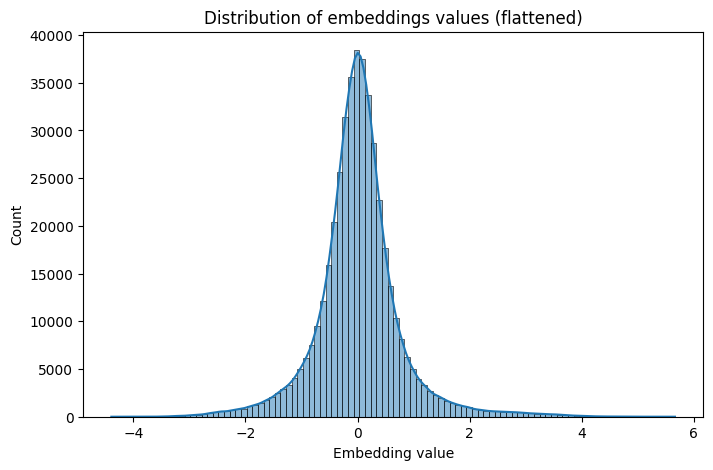

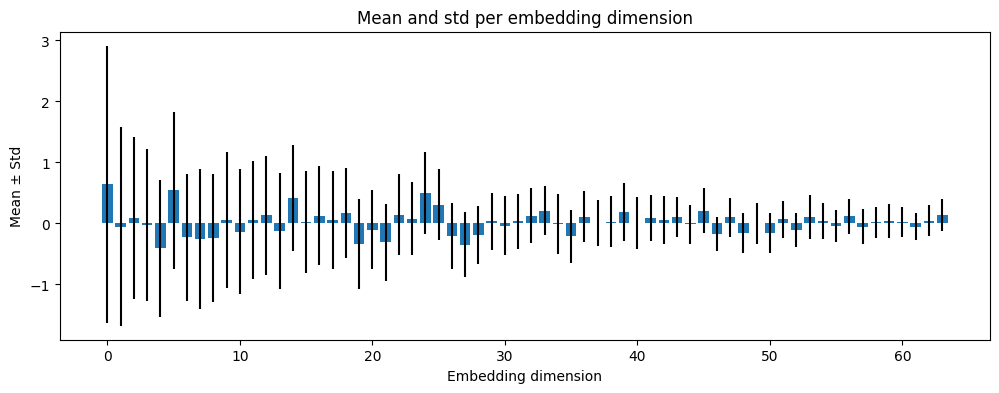

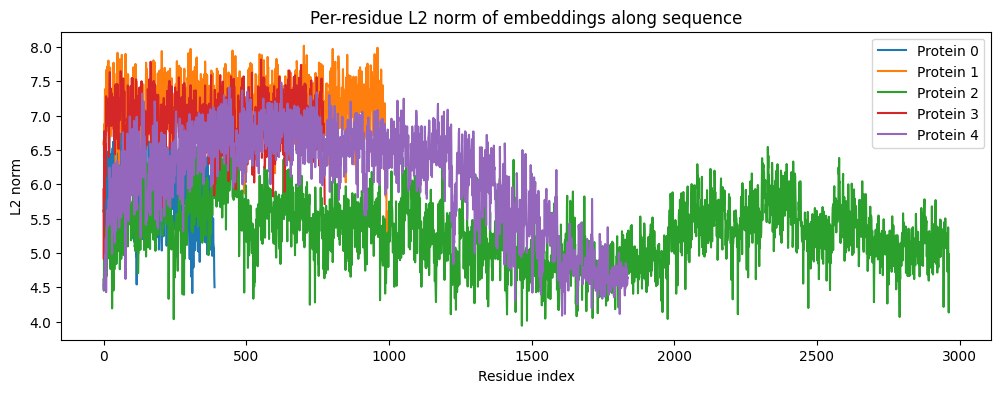

In [18]:
emb_dir_pca = "embeddings/cache_fp32_pca/train"  # folder where 64-dim ESM2 embeddings are stored after PCA
embeddings_statistics(emb_dir_pca)

Found 14995 embedding files

Protein 0 (390 residues, embedding dim 80):
Mean embedding value: 3.753792
Std deviation: 36.252384
Min: -208.645996, Max: 275.540985
L2 norm per residue: mean=325.617920

Protein 1 (994 residues, embedding dim 80):
Mean embedding value: 4.706985
Std deviation: 16.351763
Min: -41.995998, Max: 140.214996
L2 norm per residue: mean=148.835403

Protein 2 (2964 residues, embedding dim 80):
Mean embedding value: 0.421206
Std deviation: 15.620969
Min: -107.097000, Max: 101.716003
L2 norm per residue: mean=135.903778

Protein 3 (776 residues, embedding dim 80):
Mean embedding value: 4.011561
Std deviation: 22.699951
Min: -55.522999, Max: 229.576996
L2 norm per residue: mean=203.969086

Protein 4 (1838 residues, embedding dim 80):
Mean embedding value: 3.219049
Std deviation: 15.755470
Min: -70.135002, Max: 143.233002
L2 norm per residue: mean=141.118073


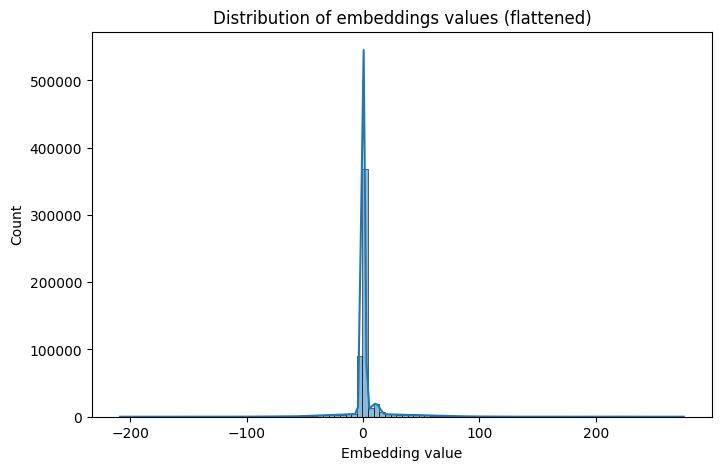

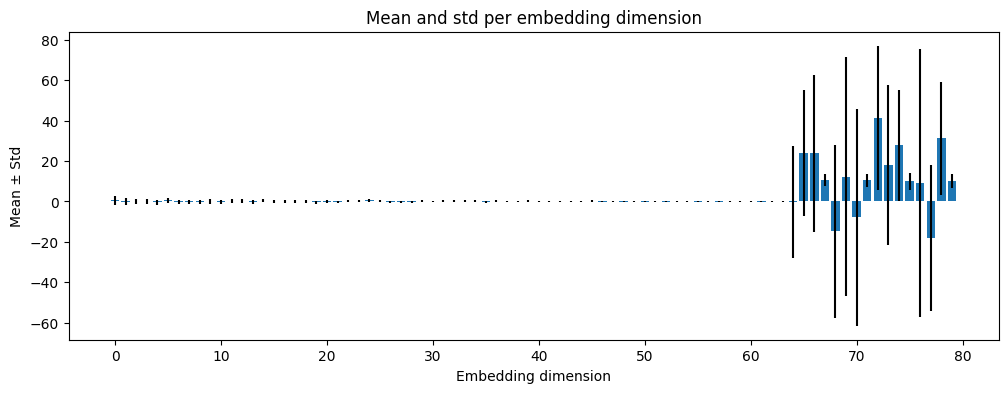

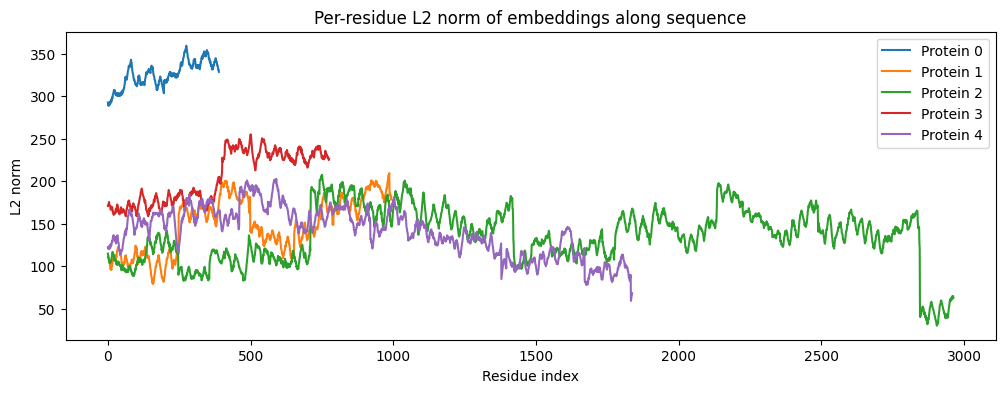

In [19]:
# folder where enriched embeddings with structural features are stored by concatenating the structural features 
# from top-3 neighbors using cosine similarity
emb_dir_cosine = "embeddings/enriched_embeddings_cosine/train" 
embeddings_statistics(emb_dir_cosine)

### We notice that even though the structural features change a lot the distribution of embedding values, they still boost training performance a lot.

Found 14995 embedding files

Protein 0 (387 residues, embedding dim 72):
Mean embedding value: 2.470522
Std deviation: 15.058923
Min: -63.938004, Max: 105.226006
L2 norm per residue: mean=129.010956

Protein 1 (183 residues, embedding dim 72):
Mean embedding value: 2.468494
Std deviation: 9.535588
Min: -3.881507, Max: 87.210999
L2 norm per residue: mean=82.939819

Protein 2 (246 residues, embedding dim 72):
Mean embedding value: 0.417875
Std deviation: 8.604603
Min: -53.439999, Max: 71.677002
L2 norm per residue: mean=72.694542

Protein 3 (156 residues, embedding dim 72):
Mean embedding value: 0.610997
Std deviation: 4.788291
Min: -38.589001, Max: 30.409332
L2 norm per residue: mean=40.423687

Protein 4 (197 residues, embedding dim 72):
Mean embedding value: 1.596131
Std deviation: 8.192413
Min: -33.633667, Max: 65.741669
L2 norm per residue: mean=70.545433


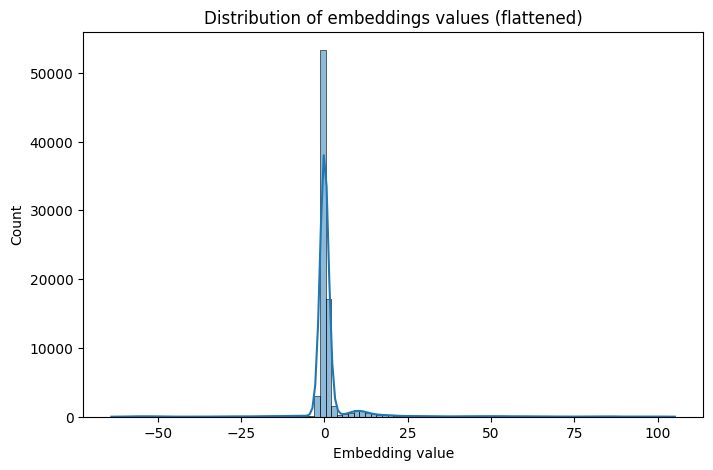

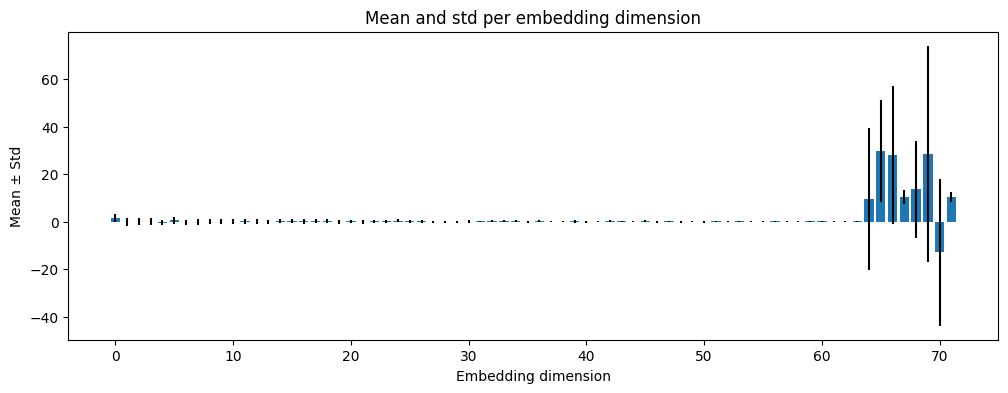

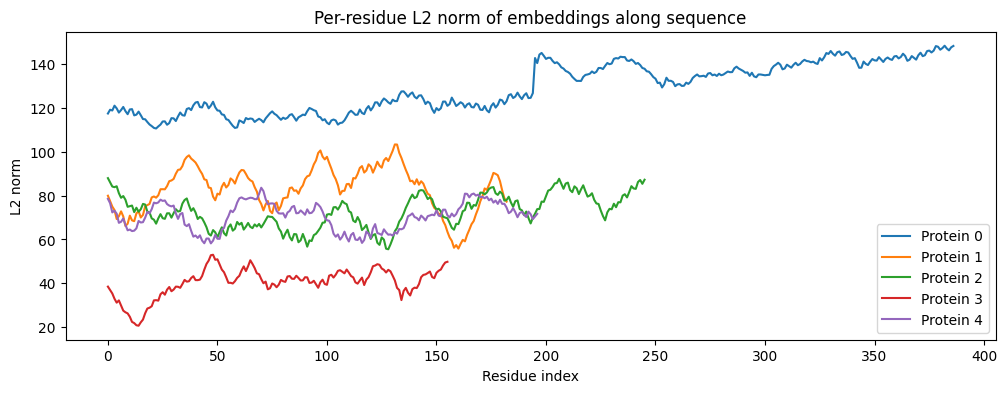

In [21]:
# folder where enriched embeddings with structural features are stored by concatenating the mean value of structural features 
# from top-3 neighbors using pairwise sequence similarity
emb_dir_pairwise = "embeddings/enriched_embeddings_pairwise/train"
embeddings_statistics(emb_dir_pairwise)